# Year 2023 Day 10

[--- Day 10: Pipe Maze ---](https://adventofcode.com/2023/day/10)



The main goal here is to show the different steps in the labyrinth resolution.

Experiment with the Observable Plot's Text mark, to add a Text mark over a Raster mark ((see example in https://observablehq.com/plot/marks/raster))


In [1]:
from typing import Any

import pandas as pd
import xarray as xr
from pyobsplot import Plot

from advent_of_code.common.common import get_example_inputs_file_contents
from advent_of_code.visualization.observable_plot import (
    build_base_xarray_plot,
)
from advent_of_code.y_2023.problem_202310 import (
    AdventOfCodeProblem202310,
    get_pipe_to_pattern_mapping,
    render_2d_array_to_text,
)

In [2]:
problem = AdventOfCodeProblem202310(config_accumulate_outputs=True)
problem

AdventOfCodeProblem202310(year=2023, day=10, config_verbose=False, config_save_img=False, config_save_txt=False, config_save_img_for_video=False, config_accumulate_outputs=True)

## Visualization Code

The following function enriches the base xarray visualization function with Observable Plot, by adding the possibility to add a text-representation of the array on the plot.

This is useful for a combined visualization of a raster and its values.

In [3]:
from advent_of_code.visualization.observable_plot import visualize_puzzle_input_202310

## With Example Inputs

### Example input from part 2 (`EXAMPLE_INPUT_PART_2_1_1a`)

#### Problem solving explanation

In the following, we visualize step by step the data structures helping to solve the problem.

In [4]:
example_inputs_2023 = get_example_inputs_file_contents(2023)["test_problem_202310"]
list(example_inputs_2023.keys())

['EXAMPLE_INPUT_1_1',
 'EXAMPLE_INPUT_1_2',
 'EXAMPLE_INPUT_1_3',
 'EXAMPLE_INPUT_2_1',
 'EXAMPLE_INPUT_2_2',
 'EXAMPLE_DISTANCES_1',
 'EXAMPLE_DISTANCES_2',
 'EXAMPLE_INPUT_PART_2_1_1a',
 'EXAMPLE_INPUT_PART_2_1_1b',
 'EXAMPLE_INPUT_PART_2_1_2',
 'EXAMPLE_INPUT_PART_2_1_TEST',
 'EXAMPLE_INPUT_PART_2_2_1',
 'EXAMPLE_INPUT_PART_2_2_2',
 'EXAMPLE_INPUT_PART_2_3_1',
 'EXAMPLE_INPUT_PART_2_3_2']

In [5]:
puzzle_input = problem.parse_text_input(
    example_inputs_2023["EXAMPLE_INPUT_PART_2_1_1a"]
)
maze = puzzle_input
minimum_distances = problem.compute_minimum_distances(maze)
result, outputs_accumulator = problem.compute_tiles_enclosed_by_loop_part_2(
    maze, minimum_distances
)
display(pd.Series(outputs_accumulator.keys()))

print("Text Input")
print(render_2d_array_to_text(outputs_accumulator["maze"]))

Current recursion limit:
3000
New recursion limit:
15000
Skipped top
Skipped left


0                 maze
1    minimum_distances
2            main_loop
3            raster_3x
4               filled
5        coarsened_img
dtype: object

Text Input
░░░░░░░░░░░░░
░░░░░░░░░░░░░
░░S───────┐░░
░░│┌─────┐│░░
░░││░░░░░││░░
░░││░░░░░││░░
░░│└─┐░┌─┘│░░
░░│░░│░│░░│░░
░░└──┘░└──┘░░
░░░░░░░░░░░░░
░░░░░░░░░░░░░


First, the main loop must be identified. The heatmap of minimal distance from starting point can be used for this. 

In [6]:
min_dist_xda = xr.DataArray(
    outputs_accumulator["minimum_distances"], dims=["row", "col"]
)

visualize_puzzle_input_202310(
    min_dist_xda,
    color=dict(legend=True, scheme="magma"),
    title="Minimum Distances",
    width=200,
)

All pipes are identified by strictly positive integers ; the starting position has a special value of $-1$, and empty space is denoted by $0$.

In [7]:
min_dist_text_xda = xr.DataArray(
    outputs_accumulator["minimum_distances"], dims=("row", "col")
)
visualize_puzzle_input_202310(
    min_dist_xda,
    text_xda=min_dist_text_xda,
    color=dict(legend=True, scheme="magma"),
    title="Minimum Distances (with values)",
    width=200,
)

The main loop can now be identified using the minimum distances.

In [8]:
main_loop_xda = xr.DataArray(outputs_accumulator["main_loop"], dims=["row", "col"])
text_xda = xr.DataArray(outputs_accumulator["maze"], dims=("row", "col"))

visualize_puzzle_input_202310(
    main_loop_xda,
    text_xda=text_xda,
    color=dict(legend=True, scheme="Observable10"),
    title="(Before) Main Loop",
    width=200,
)

The trick is to replace in pipe symbol of the Main loop by a 3x3 macro-pixel materializing this symbol:


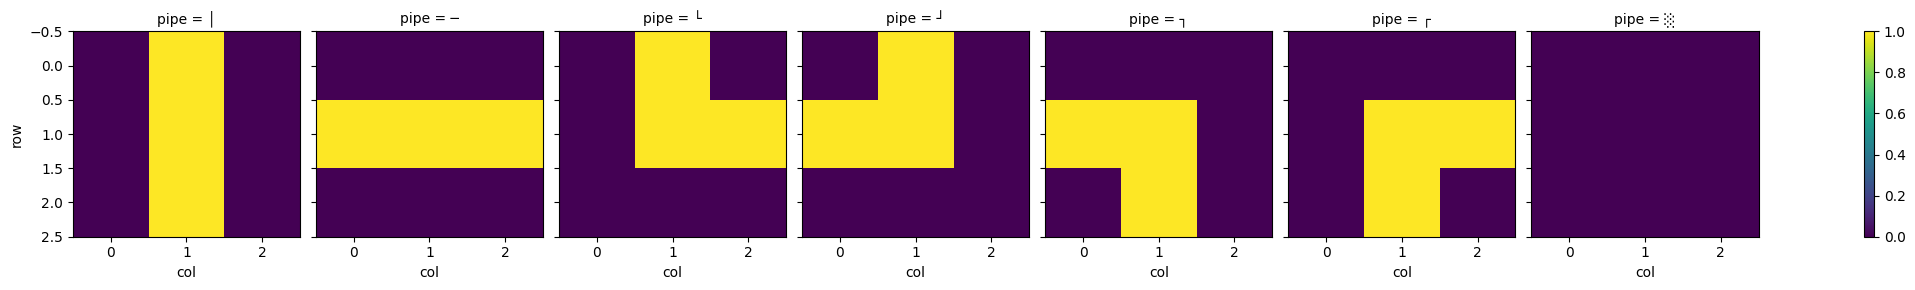

In [9]:
mapping = get_pipe_to_pattern_mapping()
mapping_xda = xr.Dataset(
    {k: xr.DataArray(v, dims=("row", "col")) for k, v in mapping.items()}
).to_array(dim="pipe")
mapping_xda.plot(y="row", x="col", col="pipe", yincrease=False)


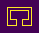

In [10]:
raster_3x_xda = xr.DataArray(outputs_accumulator["raster_3x"], dims=["row", "col"])
visualize_puzzle_input_202310(
    raster_3x_xda,
    color=dict(legend=True, scheme="viridis"),
    title="(After) Raster 3x",
    width=200,
)

Then, this new raster truly materializes the pipe network.


To find the inside area is now easy: use a [Flood Fill](https://en.wikipedia.org/wiki/Flood_fill) algorithm, for instance implemented by scipy: [skimage.morphology.flood_fill](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.flood_fill).



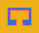

In [11]:
filled_xda = xr.DataArray(outputs_accumulator["filled"], dims=["row", "col"])
visualize_puzzle_input_202310(
    filled_xda,
    color=dict(legend=True, scheme="Observable10"),
    title="Filled (flood fill)",
    width=200,
)

The final trick is to go back to the original raster, knowing which pixels are filled.
A pixel is considered as filled if its corresponding 3x3 macro-pixel is entirely filled. This excludes the macro-pixels representing pipe from the count.


In [12]:
coarsened_img_xda = xr.DataArray(
    outputs_accumulator["coarsened_img"], dims=["row", "col"]
)
visualize_puzzle_input_202310(
    coarsened_img_xda == 255,
    color=dict(legend=True, scheme="viridis"),
    title="Coarsened 3x",
    width=200,
)

#### Recapitulation

In the following, we display all the representations of the successive intermediate data structures helping to solve the problem.

In [13]:
def visualize_puzzle_input(outputs_accumulator, with_text: bool = True, **kwargs):
    min_dist_xda = xr.DataArray(
        outputs_accumulator["minimum_distances"], dims=["row", "col"]
    )
    visualize_puzzle_input_202310(
        min_dist_xda,
        color=dict(legend=True, scheme="magma"),
        title="Minimum Distances",
        **kwargs,
    )

    if with_text:
        min_dist_text_xda = xr.DataArray(
            outputs_accumulator["minimum_distances"], dims=("row", "col")
        )
        visualize_puzzle_input_202310(
            min_dist_xda,
            text_xda=min_dist_text_xda,
            color=dict(legend=True, scheme="magma"),
            title="Minimum Distances (with values)",
            **kwargs,
        )

    main_loop_xda = xr.DataArray(outputs_accumulator["main_loop"], dims=["row", "col"])
    if with_text:
        text_xda = xr.DataArray(outputs_accumulator["maze"], dims=("row", "col"))
    else:
        text_xda = None
    visualize_puzzle_input_202310(
        main_loop_xda,
        text_xda=text_xda,
        color=dict(legend=True, scheme="Observable10"),
        title="Main Loop",
        **kwargs,
    )

    raster_3x_xda = xr.DataArray(outputs_accumulator["raster_3x"], dims=["row", "col"])
    visualize_puzzle_input_202310(
        raster_3x_xda,
        color=dict(legend=True, scheme="viridis"),
        title="Raster 3x",
        **kwargs,
    )

    filled_xda = xr.DataArray(outputs_accumulator["filled"], dims=["row", "col"])
    visualize_puzzle_input_202310(
        filled_xda,
        color=dict(legend=True, scheme="Observable10"),
        title="Filled (flood fill)",
        **kwargs,
    )

    coarsened_img_xda = xr.DataArray(
        outputs_accumulator["coarsened_img"], dims=["row", "col"]
    )
    visualize_puzzle_input_202310(
        coarsened_img_xda == 255,
        color=dict(legend=True, scheme="viridis"),
        title="Coarsened 3x",
        **kwargs,
    )

Current recursion limit:
15000
New recursion limit:
15000
Skipped top
Skipped left
Text Input
░░░░░░░░░░░░░
░░░░░░░░░░░░░
░░S───────┐░░
░░│┌─────┐│░░
░░││░░░░░││░░
░░││░░░░░││░░
░░│└─┐░┌─┘│░░
░░│░░│░│░░│░░
░░└──┘░└──┘░░
░░░░░░░░░░░░░
░░░░░░░░░░░░░



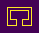


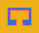

In [14]:
maze = problem.parse_text_input(example_inputs_2023["EXAMPLE_INPUT_PART_2_1_1a"])
result, outputs_accumulator = problem.compute_tiles_enclosed_by_loop_part_2(
    maze, problem.compute_minimum_distances(maze)
)

print("Text Input")
print(render_2d_array_to_text(outputs_accumulator["maze"]))

visualize_puzzle_input(outputs_accumulator, width=200)

### Example input from part 1 (`EXAMPLE_INPUT_2_1`)


Same visualization procedure.


In [15]:
maze = problem.parse_text_input(example_inputs_2023["EXAMPLE_INPUT_2_1"])
result, outputs_accumulator = problem.compute_tiles_enclosed_by_loop_part_2(
    maze, problem.compute_minimum_distances(maze)
)

print("Text Input")
print(render_2d_array_to_text(outputs_accumulator["maze"]))

visualize_puzzle_input(outputs_accumulator, width=200)

Current recursion limit:
15000
New recursion limit:
15000
Skipped top
Skipped left
Text Input
░░░░░░░
░░░┌┐░░
░░┌┘│░░
░S┘░└┐░
░│┌──┘░
░└┘░░░░
░░░░░░░


## With Actual Input

Same visualization procedure.


Current recursion limit:
15000
New recursion limit:
15000


Skipped left
Skipped right



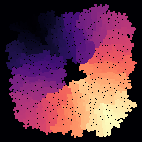


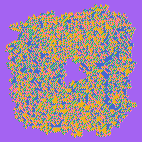


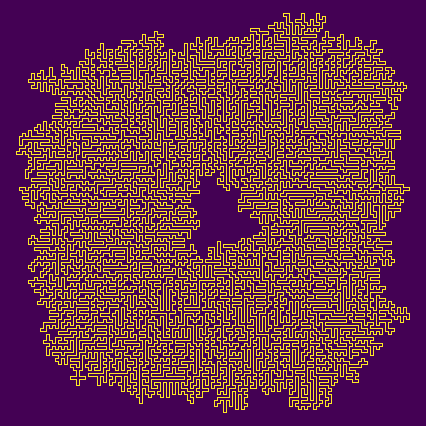


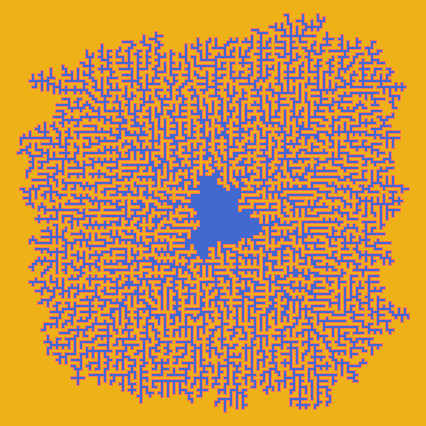


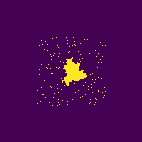

In [16]:
def visualize_actual_input(problem: AdventOfCodeProblem202310):
    maze = problem.parse_input_text_file()

    minimum_distances = problem.compute_minimum_distances(maze)
    result, outputs_accumulator = problem.compute_tiles_enclosed_by_loop_part_2(
        maze, minimum_distances
    )

    visualize_puzzle_input(
        outputs_accumulator,
        width=maze.shape[0] * 3,
        height=maze.shape[0] * 3,
        with_text=False,
    )


visualize_actual_input(problem)